# Merge the geocoded EUC and the mobility dataframe

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
euc = pd.read_csv("../datasets/EUC_geocoded_clean.csv")
mob = pd.read_excel("../datasets/Student_Mobility_2013-14.xlsx")

In [3]:
# Select only the students that are SMS mobility type
mob = mob[mob.MobilityType == "Mob-SMS"]

In [4]:
# There are no duplicates
mob.duplicated().value_counts()

False    212208
dtype: int64

In [5]:
# Select only the columns which need to be used
mob = mob[["ParticipantGender", "SendingPartnerErasmusID", "HostingPartnerErasmusID"]]

In [6]:
merge = mob.merge(euc, left_on="SendingPartnerErasmusID", right_on="Institutional code", how="inner")

In [7]:
merge = merge.merge(euc, left_on="HostingPartnerErasmusID", right_on="Institutional code", how="inner", 
                    suffixes={"Sending", "Hosting"})

In [8]:
print("Lost {:0.3f}% in the merging.".format((100 - (len(merge) / len(mob))*100)))

Lost 2.082% in the merging.


In [9]:
merge = merge[["ParticipantGender", "CountryHosting", "CountrySending" ,"coordinatesHosting", "coordinatesSending"]]

In [10]:
cmerge = merge.copy()

In [11]:
cmerge.coordinatesHosting = cmerge.coordinatesHosting.str.strip("()").str.split(",")
cmerge.coordinatesSending = cmerge.coordinatesSending.str.strip("()").str.split(",")

In [12]:
cmerge["latHosting"] = cmerge.coordinatesHosting.apply(lambda x: float(x[0]))
cmerge["lonHosting"] = cmerge.coordinatesHosting.apply(lambda x: float(x[1]))
cmerge["latSending"] = cmerge.coordinatesSending.apply(lambda x: float(x[0]))
cmerge["lonSending"] = cmerge.coordinatesSending.apply(lambda x: float(x[1]))

In [13]:
from geopy import distance

cmerge['km'] = cmerge.apply(lambda row: distance.distance(
        (row["latHosting"], row["lonHosting"]), (row["latSending"], row["lonSending"])).km, axis=1
)

In [15]:
prod = cmerge[["CountryHosting", "CountrySending","coordinatesSending", "coordinatesHosting", "km"]]

In [22]:
prod.to_csv("../checkpoints/02_corrected/data_submission/final_datasets/geocodedMobility.csv")

In [16]:
cmerge = cmerge.drop(columns=["coordinatesHosting", "coordinatesSending"])

In [200]:
cmerge.to_csv("finished_questions/travel_distance/distance_raw.csv", index=False)

In [17]:
production = cmerge.copy()

In [18]:
production = production[["CountrySending", "km"]]

In [217]:
from matplotlib import cm

In [219]:
cm.jet(len)

(0.0, 0.0, 0.517825311942959, 1.0)

In [18]:
gb = prod.groupby(by="CountrySending").mean().sort_values(by="km")

In [19]:
gb 

,km
CountrySending,
CH,761.182466
AT,923.554227
HR,953.885824
LI,969.681368
NL,1005.217117
DE,1048.100477
SI,1063.016421
BE,1075.506918
FR,1075.932036


In [226]:
cols = []
for i in range(len(gb)):
    cols.append(cm.jet(i))

In [21]:
mean = production.groupby(by="CountrySending").mean()

In [22]:
std = production.groupby(by="CountrySending").std()

In [27]:
mean["std"] = std.km

In [31]:
mean.rename(columns={"km": "km_distance", "std": "km_deviation"}).to_csv("../datasets/country_distance.csv", index=True)

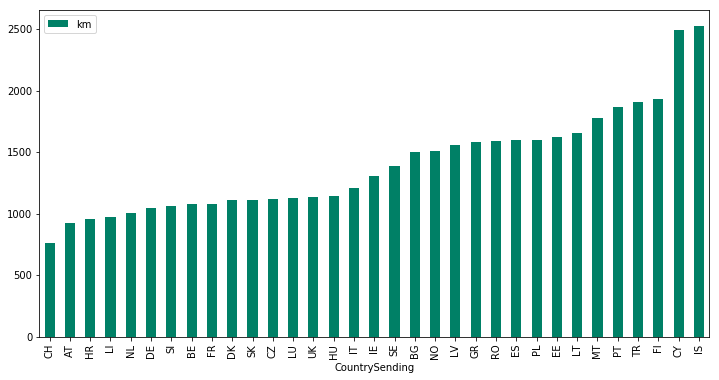

In [240]:
fig, ax = plt.subplots(figsize=(12, 6))
production.groupby(by="CountrySending").mean().sort_values(by="km").plot(kind="bar", ax=ax, colormap='summer')

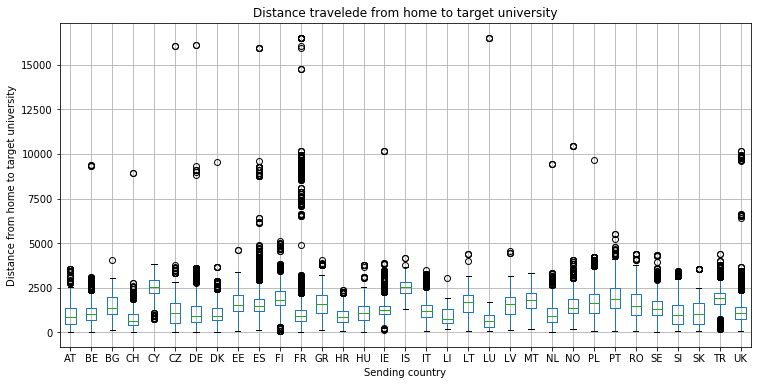

In [27]:
fig, ax = plt.subplots(figsize=(12, 6))
prod.boxplot(column="km", by="CountrySending", ax=ax)
fig.suptitle('')
ax.set_title("Distance travelede from home to target university")
ax.set_xlabel("Sending country")
ax.set_ylabel("Distance from home to target university")
plt.show()